In [2]:
import sys
import math
import numpy as np
from random import getrandbits,uniform,random,randint
from matplotlib import pyplot as plt

In [3]:
# 点坐标生成模块
from CityGenerator import CoordinateProcess


In [4]:
# 粒子群算法
# 单目标pso-w 优化方法，支持多维粒子
class ParticalSwarmOptimization:

    def __init__(self, fitness_func=None, x_interval=[-3, 3], partical_size=100,
                 partical_dimen=2, num_iter_round=100, inertial_weight=0.9,
                 c1=2, c2=2, partical_max_vel=0.5):
        self.val_func_pool = BaseEvaluationFunction()  # 未指定适应度函数的话，默认测试函数库
        self.val_func = self.val_func_pool.sphere if fitness_func is None else fitness_func  # 默认sphere适应度函数
        self.visual_plot = PlotEvaluation3D(xinterval_min=x_interval[0],
                                            xinterval_max=x_interval[1])  # 默认sphere适应度函数可视化
        self.param_min = x_interval[0]  # 解范围
        self.param_max = x_interval[1]  # 解范围

        self.partical_size = partical_size  # 粒子个数
        self.partical_dimen = partical_dimen  # 粒子维度
        self.partical_max_vel = partical_max_vel  # 粒子最大速度

        self.partical_pos = np.array([])  # 储存各粒子当前的位置向量，内部元素应该是np.arrary
        self.partical_vel = np.array([])  # 储存各粒子当前的速度向量，内部元素应该是np.arrary
        self.partical_fitness = np.array([])  # 储存各粒子当前的适应度，内部元素应该是常量

        self.partical_pb_pos = np.array([])  # 储存各粒子当前的个体历史最优位置向量，内部元素应该是np.arrary
        self.partical_gb_pos = np.zeros(self.partical_dimen)  # 粒子群当前全局最优位置

        self.partical_pb_fitness = np.array([])  # 储存各粒子当前的个体历史最优位置的适应值，内部元素应该是常量
        self.partical_gb_fitness = 0  # 粒子群当前全局最优适应度

        self.inertial_weight = inertial_weight  # 粒子惯性权重
        self.param_c1 = c1  # 位置更新常数系数
        self.param_c2 = c2  # 位置更新常数系数
        self.num_iter_round = num_iter_round  # PSO算法迭代次数

        self.gb_val_revord = []
        self.pb_val_mean_record = []

    def plot_sample(self):
        self.visual_plot.plot_sphere()

    def partial_init(self):
        '''
        :return:所有粒子位置和速度进行初始化
        '''
        self.partical_pos = np.array(
            [self.param_min + (self.param_max - self.param_min) * np.random.random(self.partical_dimen) for _ in
             range(self.partical_size)])
        self.partical_vel = np.array(
            [self.partical_max_vel * np.random.random(self.partical_dimen) for _ in range(self.partical_size)])
        self.calcult_fitness()

        self.partical_pb_fitness = np.array([0 for _ in range(self.partical_size)])
        self.partical_pb_pos = np.array([self.partical_pos[i] for i in range(self.partical_size)])

        self.partical_gb_fitness = self.partical_pb_fitness[0]
        self.partical_gb_pos = self.partical_pb_pos[0]

    def calcult_fitness(self):
        '''
        :return: 计算粒子的适应度
        '''
        self.partical_fitness = np.array([1 / self.val_func(partical_pos) for partical_pos in self.partical_pos])

    def search_pbgb(self):
        '''
        搜索粒子个体最优解和全局最优解
        :return:
        '''
        gp_flag = -1
        # 对于pb 返回一个一维0,1 np.array 0代表粒子在新位置的适应度不如历史pb,无需更改pb相关值，1代表需要进行更改
        pb_flag_list = [0 if self.partical_fitness[i] <= self.partical_pb_fitness[i] else 1 for i in
                        range(self.partical_size)]
        # 对于gp 返回一个常数Flag 如果无需更改返回-1，否则返回pb_fitness的index
        if self.partical_pb_fitness.max() > self.partical_gb_fitness:
            gp_flag = np.argmax(self.partical_pb_fitness)
        return pb_flag_list, gp_flag

    def udpate_pos_vel(self):
        '''
        更新所有粒子的速度和位置，代表向前搜索一步
        :return:
        '''
        self.partical_vel = self.inertial_weight * self.partical_vel + \
                            self.param_c1 * np.random.random() * (self.partical_pb_pos - self.partical_pos) + \
                            self.param_c2 * np.random.random() * (self.partical_gb_pos - self.partical_pos)
        self.partical_pos = self.partical_pos + self.partical_vel

    def update_pbgb(self):
        '''
        更新个体极值和当前全局最优值,(包括位置和适应值)
        :return:
        '''
        pb_flag_list, gp_flag = self.search_pbgb()
        for index in range(len(pb_flag_list)):
            flag = pb_flag_list[index]
            if flag == 1:
                self.partical_pb_pos[index] = self.partical_pos[index]
                self.partical_pb_fitness[index] = self.partical_fitness[index]
        if gp_flag != -1:
            self.partical_gb_fitness = self.partical_pb_fitness[gp_flag]
            self.partical_gb_pos = self.partical_pb_pos[gp_flag]

    def stop_control(self, iter_round_counter):
        '''
        算法迭代终止控制函数
        :param iter_round_counter:
        :return:
        '''
        return iter_round_counter >= self.num_iter_round

    def iter_info_record(self):
        '''
        记录每一次迭代粒子个体最优均值和全局最优位置的均值
        :return:
        '''
        pb_val_mean = np.array(
            [self.val_func(self.partical_pb_pos[i]) for i in range(len(self.partical_pb_pos))]).mean()
        self.pb_val_mean_record.append(pb_val_mean)
        self.gb_val_revord.append(self.val_func(self.partical_gb_pos))

    def plot_iter_info(self):
        '''
        :return: 迭代过程个体最优均值和全局最优指标绘制
        '''
        x = [iter_i for iter_i in range(1, self.num_iter_round + 1)]
        y_list = [self.pb_val_mean_record, self.gb_val_revord]
        y_lable_list = ['mean_pb_val', 'gb_val']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index], label=y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.show()

    def pso_engine(self):
        '''
        :return: 算法运行主体
        '''
        # 初始化
        self.partial_init()
        # 迭代
        iter_round_counter = 0
        while True:
            if not self.stop_control(iter_round_counter):
                self.calcult_fitness()
                self.search_pbgb()
                self.update_pbgb()
                self.udpate_pos_vel()
                self.iter_info_record()
                iter_round_counter += 1
            else:
                break
        return self.plot_iter_info()
    

In [7]:
class PsoTsp:
    def __init__(self, city_coord, distance_matrix, partical_size=50, iter_round=1000, inertial_weight=0.9,
                 c1=2, c2=2):
        self.city_coord = city_coord  # 城市坐标
        self.distance_matrix = distance_matrix  # 距离矩阵
        self.sorted_edge = self.cal_sorted_edge()  # 计算距离排序矩阵
        
        self.partical_size = partical_size  # 粒子个数
        self.iter_round = iter_round  # 迭代次数
        self.inertial_weight = inertial_weight  # 惯性系数
        self.var_c1 = c1  # 常数系数c1
        self.var_c2 = c2  # 常数系数c2
        
        self.partical_pos = []  # 粒子群位置列表
        self.partical_vel = []  # 粒子群速度列表
        self.partical_fitness = []  # 粒子群适应度列表
    
        # 产生随机粒子
    def __encode(self):
        init_particle = [i for i in range(len(self.city_coord))]
        np.random.shuffle(init_particle)
        return init_particle
    
    #  停止控制
    def stop_control(self, iter_round_counter):
        '''
        算法迭代终止控制函数
        :param iter_round_counter:
        :return:
        '''
        return iter_round_counter >= self.iter_round
    
    # 计算距离排序矩阵
    def cal_sorted_edge(self):
        res_list = []
        cp_distance_matrix = self.distance_matrix.copy()
        for edge_index in range(len(cp_distance_matrix)):
            distance_edge = cp_distance_matrix[edge_index]
            distance_edge[edge_index] = sys.maxsize
            tmp_container = []
            while len(tmp_container) < len(distance_matrix)-1:
                min_distance, min_index = np.min(distance_edge), np.argmin(distance_edge)
                tmp_container.append(min_index)
                distance_edge[min_index] = sys.maxsize
            res_list.append(tmp_container)
        return res_list
    
    # 计算短边库长度参数m
    def cal_m(self, iter_round):
        N = len(self.city_coord)
        return round((N-1) - (N-5)*iter_round/self.iter_round)
    
    
        


3628800

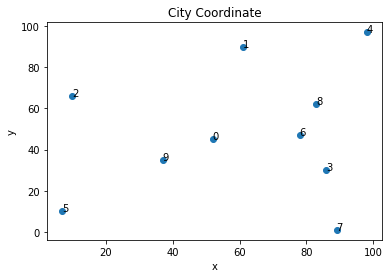

In [15]:
# 点坐标、距离矩阵
coord_generator = CoordinateProcess(num_cities=10, min_coord=1, max_coord=100)
coord_generator.plot_cities()
city_coord = coord_generator.coordinate
distance_matrix = coord_generator.distance_matrix

In [16]:
test_pso = PsoTsp(city_coord, distance_matrix,
                  partical_size=50, iter_round=1000, inertial_weight=0.9,c1=2, c2=2)

In [17]:
test_pso.distance_matrix

array([[  0.        ,  45.89117562,  46.95742753,  37.16180835,
         69.42621983,  57.00877125,  26.07680962,  57.48912941,
         35.35533906,  18.02775638],
       [ 45.89117562,   0.        ,  56.36488268,  65.        ,
         37.65634077,  96.5194281 ,  46.23851209,  93.30058949,
         35.60898763,  60.00833275],
       [ 46.95742753,  56.36488268,   0.        ,  84.09518417,
         93.30058949,  56.08029957,  70.60453243, 102.30347013,
         73.10950691,  41.10960958],
       [ 37.16180835,  65.        ,  84.09518417,   0.        ,
         68.0661443 ,  81.49233093,  18.78829423,  29.15475947,
         32.14031736,  49.25444142],
       [ 69.42621983,  37.65634077,  93.30058949,  68.0661443 ,
          0.        , 125.89678312,  53.85164807,  96.42095208,
         38.07886553,  86.97700846],
       [ 57.00877125,  96.5194281 ,  56.08029957,  81.49233093,
        125.89678312,   0.        ,  80.0624756 ,  82.49242389,
         92.08691547,  39.05124838],
       [ 2

In [18]:
test_pso.sorted_edge

[[9, 6, 8, 3, 1, 2, 5, 7, 4],
 [8, 4, 0, 6, 2, 9, 3, 7, 5],
 [9, 0, 5, 1, 6, 8, 3, 4, 7],
 [6, 7, 8, 0, 9, 1, 4, 5, 2],
 [1, 8, 6, 3, 0, 9, 2, 7, 5],
 [9, 2, 0, 6, 3, 7, 8, 1, 4],
 [8, 3, 0, 9, 1, 7, 4, 2, 5],
 [3, 6, 0, 8, 9, 5, 1, 4, 2],
 [6, 3, 0, 1, 4, 9, 7, 2, 5],
 [0, 5, 2, 6, 3, 8, 1, 7, 4]]